In [198]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

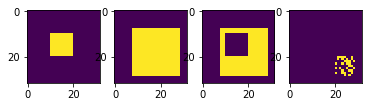

In [199]:
dna_seg = np.zeros((32,32))
dna_seg[10:20,10:20] = 1
mem_seg = np.zeros((32,32))
mem_seg[8:29,8:29] = 1
cyt_seg = mem_seg.copy()
cyt_seg[dna_seg==1] = 0
str_seg = np.random.randint(2, size=32*32).reshape(32,32)
str_seg[:20,:] = 0; str_seg[:,:20] = 0;
str_seg = str_seg*cyt_seg
fig, ax = plt.subplots(1,4)
ax[0].imshow(dna_seg)
ax[1].imshow(mem_seg)
ax[2].imshow(cyt_seg)
ax[3].imshow(str_seg)

In [273]:
def get_dispersion_features(image1_seg, image2_seg, normalize=True, number_of_samples=25, repetitions=400):

    coords = []
    coords.append(np.nonzero(image1_seg))
    coords.append(np.nonzero(image2_seg))

    for i in range(2):
        coords[i] = np.asarray(coords[i]).T
        coords[i] = coords[i] + (np.random.rand(*coords[i].shape)-0.5)
    
    centroid = []
    diameter = []
    for i in range(2):
        centroid.append(coords[i].mean(axis=0))
        diameter.append(np.sqrt(((coords[i]-centroid[i])**2).sum(axis=1)).max())

    print(centroid[0],centroid[1])
    print(diameter[0],diameter[1])

    # Finding the reference set as the one with largest
    # diameter, usually the cytoplasm
    
    reference = 0 if diameter[0] > diameter[1] else 1
    
    # Shifting to the origin of reference set
    
    for i in range(2):
        coords[i] = coords[i] - centroid[reference]
    
    # Normalization by the diameter

    if normalize:
        for i in range(2):
            coords[i] /= diameter[reference]

    samples = []
    for i in [reference,1-reference,reference]:
        idx = np.random.choice(np.arange(coords[i].shape[0]), size=number_of_samples, replace=False)
        samples.append(coords[i][idx,:])

    fig, ax = plt.subplots(1,3,figsize=(15,5))
    for i in range(3):
        ax[i].plot(samples[i][:,1],samples[i][:,0],"o")
        ax[i].set_xlim(-1,1)
        ax[i].set_ylim(-1,1)
    plt.show()

    dist_matrix_str = cdist(samples[0], samples[1])
    dist_matrix_ctl = cdist(samples[0], samples[2])
    
    match_str_row, match_str_col = linear_sum_assignment(dist_matrix_str)
    match_ctl_row, match_ctl_col = linear_sum_assignment(dist_matrix_str)
    
    match_str_local_col = np.argmin(dist_matrix_str,axis=1)
    match_str_local_row = np.argmin(dist_matrix_str,axis=0)
    match_ctl_local_col = np.argmin(dist_matrix_ctl,axis=1)
    match_ctl_local_row = np.argmin(dist_matrix_ctl,axis=0)

    fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,5))
    ax[0].plot(samples[0][:,1],samples[0][:,0],"ro")
    ax[0].plot(samples[1][:,1],samples[1][:,0],"bo")
    ax[0].plot([samples[0][:,1],samples[1][match_str_col,1]],[samples[0][:,0],samples[1][match_str_col,0]],"r-")
    ax[1].plot(samples[0][:,1],samples[0][:,0],"ro")
    ax[1].plot(samples[1][:,1],samples[1][:,0],"bo")
    ax[1].plot([samples[0][:,1],samples[1][match_str_local_col,1]],[samples[0][:,0],samples[1][match_str_local_col,0]],"r-")
    ax[1].plot([samples[0][match_str_local_row,1],samples[1][:,1]],[samples[0][match_str_local_row,0],samples[1][:,0]],"b-")
    plt.show()

    fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,5))
    ax[0].plot(samples[0][:,1],samples[0][:,0],"ro")
    ax[0].plot(samples[2][:,1],samples[2][:,0],"bo")
    ax[0].plot([samples[0][:,1],samples[2][match_ctl_col,1]],[samples[0][:,0],samples[2][match_ctl_col,0]],"r-")
    ax[1].plot(samples[0][:,1],samples[0][:,0],"ro")
    ax[1].plot(samples[2][:,1],samples[2][:,0],"bo")
    ax[1].plot([samples[0][:,1],samples[2][match_ctl_local_col,1]],[samples[0][:,0],samples[2][match_ctl_local_col,0]],"r-")
    ax[1].plot([samples[0][match_ctl_local_row,1],samples[2][:,1]],[samples[0][match_ctl_local_row,0],samples[2][:,0]],"b-")
    plt.show()

    cost_str_mean = dist_matrix_str[match_str_row, match_str_col].mean()
    cost_ctl_mean = dist_matrix_ctl[match_ctl_row, match_ctl_col].mean()
    cost_str_local_mean = np.mean([dist_matrix_str[np.arange(len(match_str_local_col)), match_str_local_col],dist_matrix_str[match_str_local_row, np.arange(len(match_str_local_col))]])
    cost_ctl_local_mean = np.mean([dist_matrix_ctl[np.arange(len(match_ctl_local_col)), match_ctl_local_col],dist_matrix_ctl[match_ctl_local_row, np.arange(len(match_ctl_local_col))]])

    cost_str_std = dist_matrix_str[match_str_row, match_str_col].std()
    cost_ctl_std = dist_matrix_ctl[match_ctl_row, match_ctl_col].std()
    cost_str_local_std = np.std([dist_matrix_str[np.arange(len(match_str_local_col)), match_str_local_col],dist_matrix_str[match_str_local_row, np.arange(len(match_str_local_col))]])
    cost_ctl_local_std = np.std([dist_matrix_ctl[np.arange(len(match_ctl_local_col)), match_ctl_local_col],dist_matrix_ctl[match_ctl_local_row, np.arange(len(match_ctl_local_col))]])
    
    print("Cost mean:",cost_str_mean, cost_str_local_mean)
    print("Cost mean:",cost_ctl_mean, cost_ctl_local_mean)

    print("Cost std:",cost_str_std, cost_str_local_std)
    print("Cost std:",cost_ctl_std, cost_ctl_local_std)
    
    features = {}
    return dist_matrix_str, match_str_local_col, match_str_local_row

[23.58534754 24.30887429] [19.01135338 19.04637544]
5.211360515519137 15.57723908180898


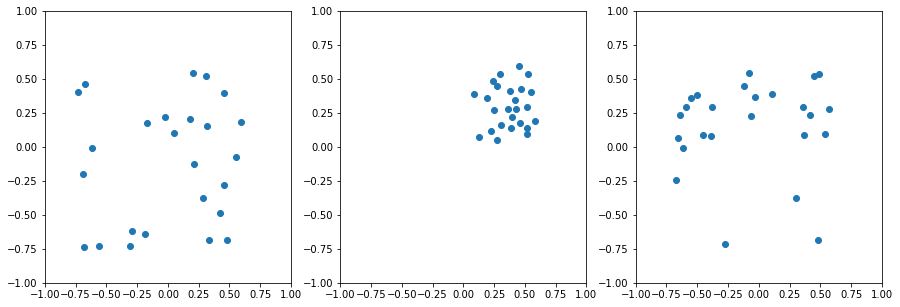

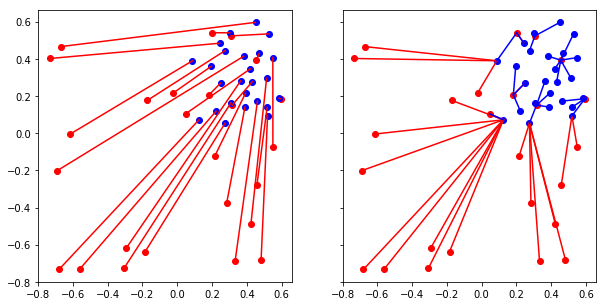

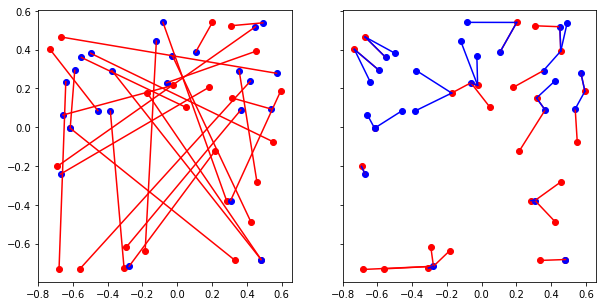

Cost mean: 0.6233815304424093 0.28690736377605025
Cost mean: 0.8226041294943421 0.13398134429321737
Cost std: 0.3939718046126134 0.3225243941388809
Cost std: 0.36361655347159694 0.08481343588523343


In [274]:
m, cols, rows = get_dispersion_features(image1_seg=str_seg, image2_seg=cyt_seg)